In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.vaep.formula as vaepformula

In [2]:
## Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [3]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
    actiontypes = spadlstore["atomic_actiontypes"]
    bodyparts = spadlstore["bodyparts"]
print("nb of games:", len(games))

nb of games: 64


In [4]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.read_hdf(spadl_h5, f"atomic_actions/game_{game.game_id}")
    actions = (
        actions
        .merge(actiontypes, how="left")
        .merge(bodyparts, how="left")
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 64/64 [00:05<00:00, 11.36it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name', 'scores', 'concedes', 'offensive_value', 'defensive_value',
       'vaep_value'],
      dtype='object')

In [5]:
# Use this if you want to assign credit for the receival back to the initial passer
# A["player_id"] = A.player_id.mask(A.type_name == "receival", A.player_id.shift(1))

### Most valuable players

In [6]:
A["count"] = 1

playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
6,3009.0,Kylian Mbappé,5.436931,5.094823,0.342108,721
44,3289.0,Romelu Lukaku,5.045655,4.863486,0.182169,399
172,5207.0,Cristiano Ronaldo,4.831209,4.284829,0.546380,463
92,3621.0,Eden Hazard,4.624565,4.492885,0.131680,1035
122,4320.0,Neymar,4.359481,4.369841,-0.010360,1118
265,5487.0,Antoine Griezmann,4.328298,3.975121,0.353177,811
36,3244.0,John Stones,3.994693,2.746433,1.248259,1454
161,5195.0,Artem Dzyuba,3.861066,3.561175,0.299891,426
209,5246.0,Luis Suárez,3.640865,3.424123,0.216741,518
71,3501.0,Philippe Coutinho,3.624610,3.347816,0.276794,1057


In [7]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
#stats[stats.offensive_rating > 0.1]
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating
34,3237.0,Sergio Agüero,2.713746,2.653681,0.060065,210,193,1.265478,1.237468
172,5207.0,Cristiano Ronaldo,4.831209,4.284829,0.546380,463,381,1.141231,1.012164
117,4269.0,Aleksandar Mitrović,3.380721,3.191525,0.189196,279,271,1.122749,1.059916
75,3531.0,Mohamed Salah,2.298034,2.247521,0.050514,181,189,1.094302,1.070248
251,5473.0,Ahmed Musa,2.662630,2.093960,0.568670,244,220,1.089258,0.856620
161,5195.0,Artem Dzyuba,3.861066,3.561175,0.299891,426,339,1.025062,0.945445
164,5198.0,Diego Costa,3.452023,3.340622,0.111401,271,315,0.986292,0.954463
152,5186.0,Denis Cheryshev,3.312992,4.081997,-0.769005,332,312,0.955671,1.177499
29,3196.0,Wahbi Khazri,2.792433,2.531294,0.261139,286,264,0.951966,0.862941
44,3289.0,Romelu Lukaku,5.045655,4.863486,0.182169,399,488,0.930551,0.896954


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-07-02 20:00:00 Belgium 3-2 Japan 93' receival 4831.0


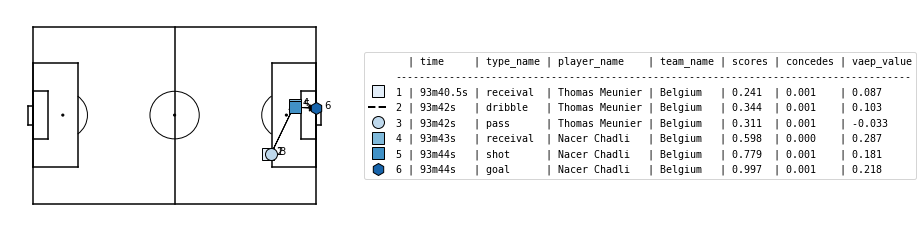

2018-06-28 20:00:00 England 0-1 Belgium 9' dribble 3457.0


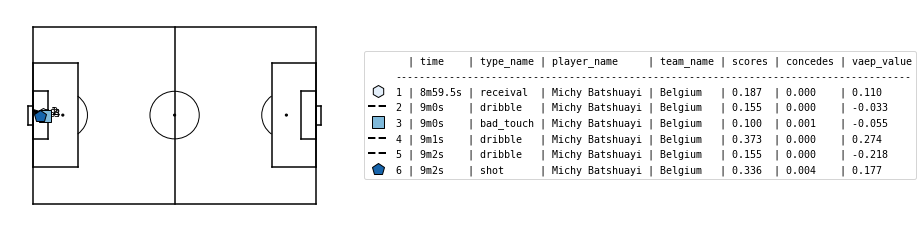

2018-06-23 14:00:00 Belgium 5-2 Tunisia 47' receival 3289.0


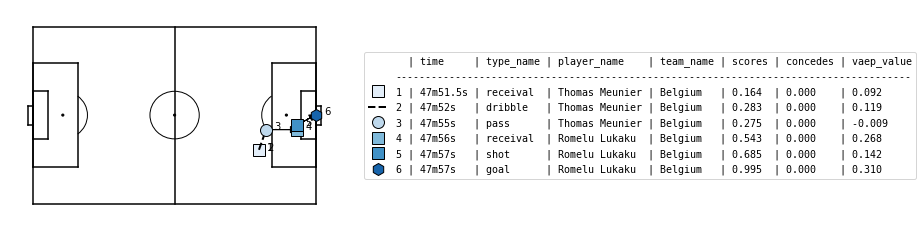

2018-07-02 20:00:00 Belgium 3-2 Japan 53' receival 5642.0


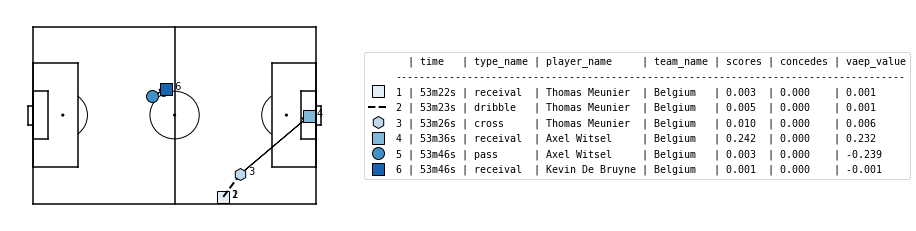

2018-07-14 16:00:00 Belgium 2-0 England 3' receival 3176.0


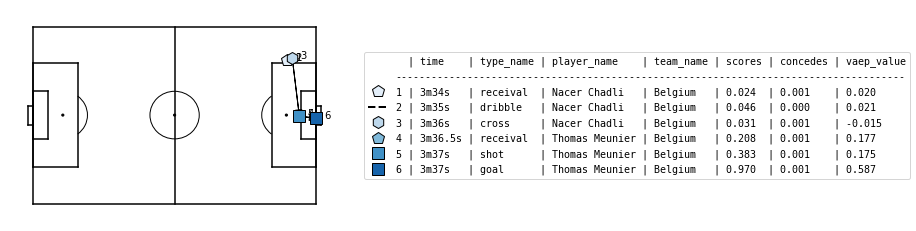

2018-07-02 20:00:00 Belgium 3-2 Japan 48' dribble 3621.0


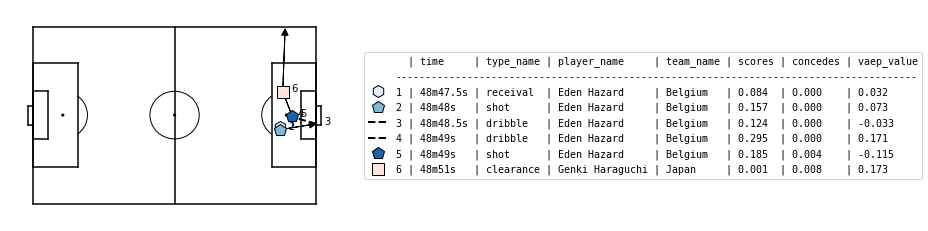

2018-06-23 14:00:00 Belgium 5-2 Tunisia 89' receival 3457.0


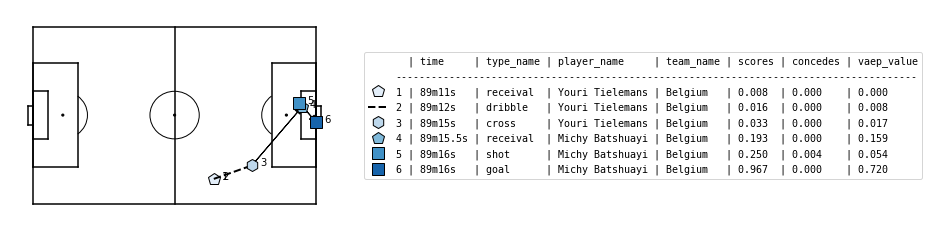

2018-06-28 20:00:00 England 0-1 Belgium 35' receival 5639.0


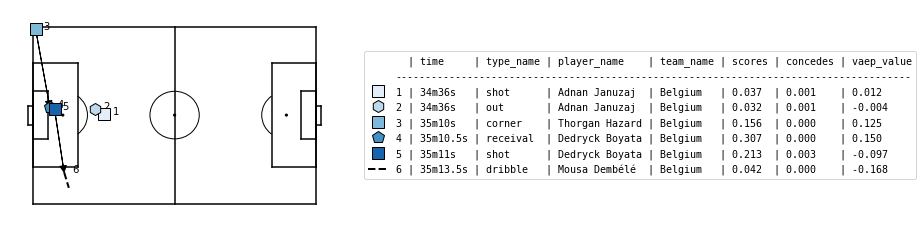

2018-07-02 20:00:00 Belgium 3-2 Japan 61' receival 3289.0


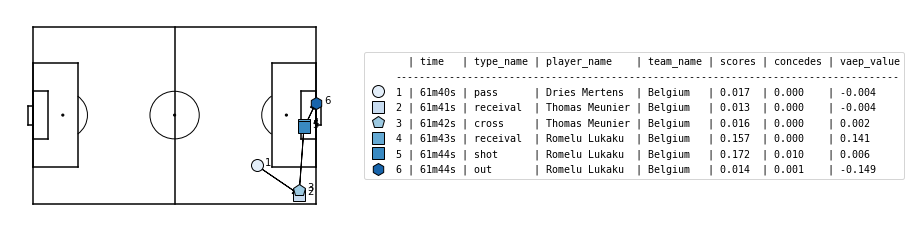

2018-07-10 20:00:00 France 1-0 Belgium 21' receival 3101.0


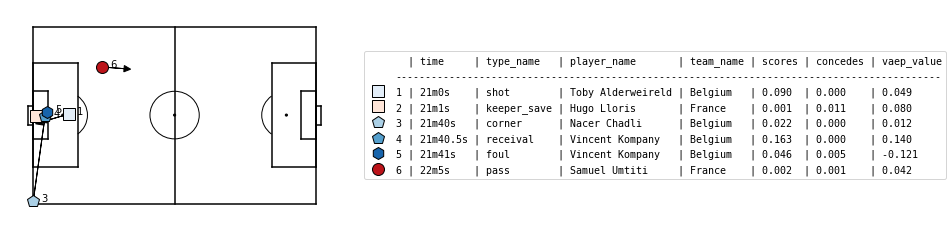

In [8]:
import matplotsoccer

sorted_A = A.sort_values("offensive_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.isin(["goal", "shot", "shot_penalty"])] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1) * 45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i + 3].copy()
    
    a["player_name"] = a[["nickname" ,"player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id - 1) * 45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_id}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "concedes", "vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x", "y", "end_x", "end_y"]],
                a.type_name,
                team=a.team_name,
                label=a[cols],
                labeltitle = cols,
                zoom=False)